In [1]:
import torch
# from transformers import OPTForCausalLM, AutoModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer
# from chemlactica.utils.utils import get_tokenizer
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from rdkit.Chem import RDConfig, QED

from rdkit.Chem.rdMolDescriptors import CalcTPSA
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from sklearn.metrics import mean_squared_error


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("/auto/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066")
orig_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
cus_tokenizer = AutoTokenizer.from_pretrained("/auto/home/menuab/code/ChemLactica/chemlactica/tokenizer/GemmaTokenizer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [42]:
tokenizer.encode("[SIMILAR][/SIMILAR][PROPERTY][/PROPERTY][SYNONYM][/SYNONYM]")

[50002, 50035, 50003, 50036, 50000, 50033]

In [3]:
orig_tokenizer.add_bos_token = False

In [3]:
# model_path = "/auto/home/menuab/code/checkpoints/9954e52e400b43d18d3a40f6/125m_122k_9954"
# model_path = "/auto/home/menuab/code/checkpoints/26d322857a184fcbafda5d4a/125m_118k_26d3/"
model_path = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/d779400877344b57b495c8f2/last"
model_path = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/504e413cfff2463db5dd37e4/last"
model_path = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/8f4502ae5c354475be62125d/checkpoint-8000"
model_2b_16k_a3f8 = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/a3f81bf063a14e8289ed0c0c/checkpoint-16000/"
# OPTForCausalLM.__init__ = cast_lm_head_to_fp32_init(OPTForCausalLM.__init__)
model_2b_11k_d6e6 = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/d6e6a76e91814ad68d5fa264/checkpoint-11000"

model = AutoModelForCausalLM.from_pretrained(model_2b_11k_d6e6,torch_dtype=torch.float16).eval().to('cuda:1')

# model = 

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:55<00:00, 27.74s/it]


In [16]:
model_125m_20k_9954 = "/nfs/dgx/raid/chem/checkpoints/facebook/galactica-125m/9954e52e400b43d18d3a40f6/checkpoint-20480"
model2 = AutoModelForCausalLM.from_pretrained(model_125m_20k_9954,torch_dtype=torch.float16).eval().to('cuda:1')


In [62]:
prompt = f"<bos>[QED]0.02[/QED][START_SMILES]"
len_prompt = len(prompt)
prompt = cus_tokenizer(prompt, return_tensors="pt").to(model.device)
output = model.generate(prompt.input_ids, do_sample=False, max_length=30, return_dict_in_generate=True ,output_scores=True)
out = cus_tokenizer.batch_decode(output)
out

TypeError: argument 'ids': Can't extract `str` to `Vec`

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,
          1.,   0.,   1.,   2.,   1.,   0.,   0.,   2.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   3.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,
          0.,   0.,   3.,   2.,   1.,   1.,   2.,   1.,   1.,   1.,   2.,
          2.,   1.,   1.,   0.,   1., 

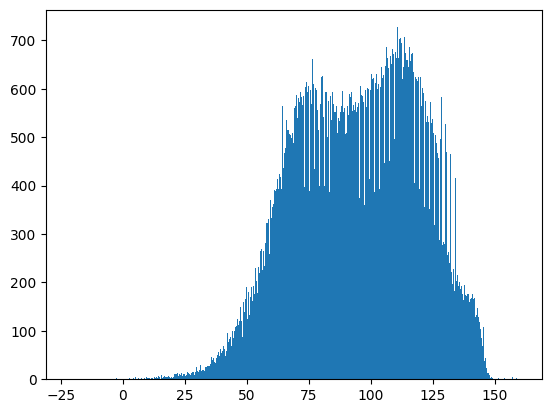

In [60]:
plt.hist(output['scores'][1].cpu().numpy()[0], bins=1000)

In [8]:
prompt = f"<bos>[QED]0.23[/QED]"
len_prompt = len(prompt)
cus_tokenizer(prompt, return_tensors="pt")

{'input_ids': tensor([[     2,     18, 235276, 235265, 235284, 235304,     52]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [19]:
for i in range(0, len(out), 120):
    print(out[i:i+120])

</s>[START_SMILES]CC(C)(C)OC(=O)N1CCCC1C(=O)N1CCCC1C(=O)NC(Cc1ccc(O)cc1)C(=O)O[END_SMILES][SIMILAR]CC(C)CC(NC(=O)C(Cc1cc
c(O)cc1)NC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CCCN=C(N)N)NC(=O)C(CCCCN)NC(=O)C(CCCCN)NC(=O)C(N)CCCCN)C(=O)O 0.269709543
5684647[/SIMILAR][SIMILAR]CC(C)CC(NC(=O)C(Cc1ccc(O)cc1)NC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CCCN=C(N)N)NC(=O)C(CCCCN)N
C(=O)C(N)CCCCN)C(=O)O 0.30985915492957744[/SIMILAR][SIMILAR]CC(


In [13]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(0,100, 1):
    prompt = f"<bos>[TPSA]{i:.2f}[/TPSA]"
    len_prompt = len(prompt)
    prompt = cus_tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=20, max_length=300)
    out = cus_tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            tpsa_score = round(AllChem.CalcTPSA(Chem.MolFromSmiles(smiles)), 2)
            diff = abs(i - tpsa_score)
            print("GT:", i, "Gen:", tpsa_score, "diff:", round(diff,2), smiles, out )
            ground_truths.append(i)
            gens.append(tpsa_score)
            diffs.append(diff)
        else:
            print(f"GT: {i} {out}")
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

GT: 0 Gen: 0.0 diff: 0.0 CC1=C(C)C(C)C([Si](C)(C)C2C(C)=C(C)C(C)=C2C)=C1C <bos>[TPSA]0.00[/TPSA][NUMROTATABLEBONDS]1[/NUMROTATABLEBONDS][RINGCOUNT]2[/RINGCOUNT][START_SMILES]CC1=C(C)C(C)C([Si](C)(C)C2C(C)=C(C)C(C)=C2C)=C1C[END_SMILES][NHOHCOUNT]0[/NHOHCOUNT][FORMULA]C21H34Si[/FORMULA][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NOCOUNT]0[/NOCOUNT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHACCEPTORS]
GT: 1 Gen: 3.24 diff: 2.24 CC(C)C1CCCN(CC2CC2)CC1 <bos>[TPSA]1.00[/TPSA][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][START_SMILES]CC(C)C1CCCN(CC2CC2)CC1[END_SMILES][NHOHCOUNT]0[/NHOHCOUNT][RINGCOUNT]2[/RINGCOUNT][NUMSATURATEDHETEROCYCLES]1[/NUMSATURATEDHETEROCYCLES][NUMALIPHATICRINGS]2[/NUMALIPHATICRINGS][CLOGP]3.40[/CLOGP][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NOCOUNT]1[/NOCOUNT][NUMHDONORS]0[/NUMHDONORS][NUMAROMATICRINGS]0[/NUMAROMATICRINGS][NUMAROMATICCARBOCYCLES]0[/NUMAROMATICCARBOCYCLES][NUMHACCEPTORS]
GT: 2 Gen: 0.0 diff: 2.0 CC1(C)C(C(Br)c2cc(Br)

In [ ]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,100),(0,100))
plt.title(f"tpsa {rmse=}")
plt.grid(True)


12.459650836985436


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(0,0.96, 0.01):
    prompt = f"<bos>[QED]{i:.2f}[/QED]"
    len_prompt = len(prompt)
    prompt = cus_tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=cus_tokenizer.encode("[END_SMILES]")[0], \
                         suppress_tokens=[2, 10, 44, 11, 45, 12, 46, 13, 47], repetition_penalty=1.004, renormalize_logits=True,max_length=1000)
    out = cus_tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            # tpsa_score = AllChem.CalcTPSA(Chem.MolFromSmiles(smiles))
            qed_score = QED.qed(Chem.MolFromSmiles(smiles))
            qed_score = round(qed_score, 2)
            diff = abs(i - qed_score)
            print(out)
            print("GT:", i, "Gen:", qed_score, "diff:", round(diff,2), smiles )
            ground_truths.append(i)
            gens.append(qed_score)
            diffs.append(diff)
        else:
            print("****")
            print(f"GT: {i} {out}")
            invalids += 1
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

<bos>[QED]0.00[/QED][NUMAROMATICCARBOCYCLES]12[/NUMAROMATICCARBOCYCLES][FORMULA]C154H193ClN18O27S[/FORMULA][START_SMILES]CC(C)(C)OC(=O)N1CCC(C(=O)O)CC1.CC(C)(C)OC(=O)N1CCC(C(=O)c2ccc(Cl)cc2)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.NC(=O)C1CCN(C(=O)c2ccc(Cl)cc2)CC1.NC(=O)C1CCN(C(=O)c2ccc(Cl)cc2)CC1[END_SMILES]
GT: 0.0 Gen: 0.05 diff: 0.05 CC(C)(C)OC(=O)N1CCC(C(=O)O)CC1.CC(C)(C)OC(=O)N1CCC(C(=O)c2ccc(Cl)cc2)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.CC(C)(C)OC(=O)N1CCC(C(N)=O)CC1.NC(=O)C1CCN(C(=O)c2ccc(Cl)cc2)CC1.NC(=O)C1CCN(C(=O)c2ccc(Cl)cc2)CC1
****
GT: 0.01 <bos>[QED]0.01[/QED][RINGCOUNT]2[/RINGCOUNT][F

KeyboardInterrupt: 

0.09502192729400233


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


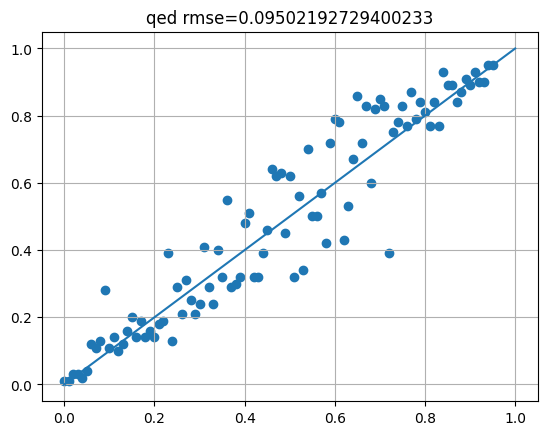

In [11]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,1),(0,1))
plt.title(f"qed {rmse=}")
plt.grid(True)

0.09201641851645685


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


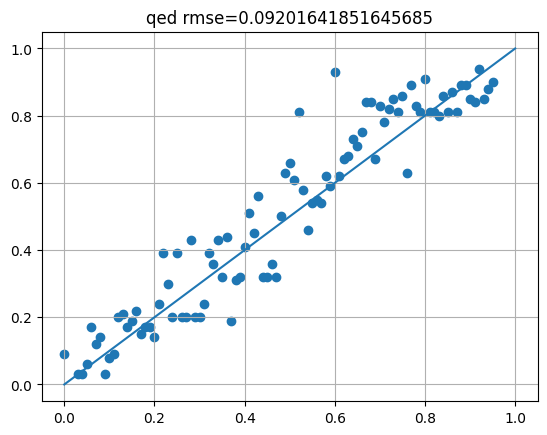

In [5]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,1),(0,1))
plt.title(f"qed {rmse=}")
plt.grid(True)

In [12]:
invalids

0

In [28]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(0,0.96, 0.01):
    prompt = f"</s>[QED]{i:.2f}[/QED]"
    len_prompt = len(prompt)
    prompt = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model2.generate(prompt.input_ids, do_sample=False, eos_token_id=20, suppress_tokens = [2, 50002, 50035, 50003, 50036, 50000, 50033]
                         ,repetition_penalty=1.01
                         , max_length=1000)
    out = tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            # tpsa_score = AllChem.CalcTPSA(Chem.MolFromSmiles(smiles))
            qed_score = QED.qed(Chem.MolFromSmiles(smiles))
            qed_score = round(qed_score, 2)
            diff = abs(i - qed_score)
            print("GT:", i, "Gen:", qed_score, "diff:", round(diff,2), smiles, out )
            ground_truths.append(i)
            gens.append(qed_score)
            diffs.append(diff)
        else:
            print("****")
            print(f"GT: {i} {out}")
            invalids += 1
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

GT: 0.0 Gen: 0.01 diff: 0.01 CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1.CC(C)(C)OC(=O)NCCCC(=O)Nc1ccc(C(=O)O)cc1 </s>[QED]0.00[/QED][NUMHETEROATOMS]102[/NUMHETEROATOMS][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMAROMATICCARBOCYCLES]12[/NUMAROMATICCARBOCYCLES][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][SAS]9.8

In [29]:
invalids

0

0.06982865935034603


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


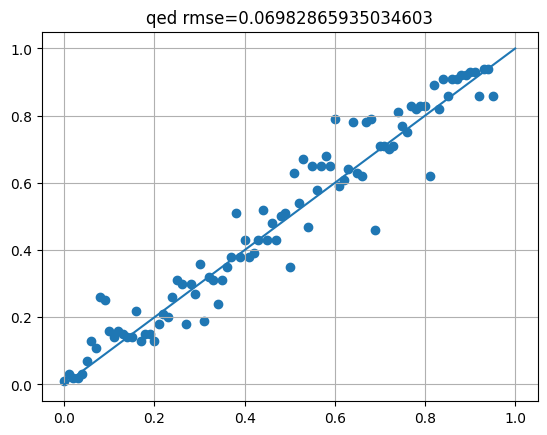

In [30]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,1),(0,1))
plt.title(f"qed {rmse=}")
plt.grid(True)

0.3806411949569379


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


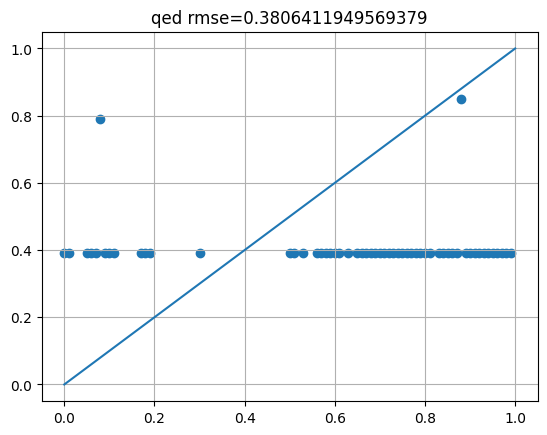

In [35]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,1),(0,1))
plt.title(f"qed {rmse=}")
plt.grid(True)

In [ ]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(1,10, 0.1):
    prompt = f"<bos>[SAS]{i:.2f}[/SAS]"
    len_prompt = len(prompt)
    prompt = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=20, max_length=300)
    out = tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            # tpsa_score = AllChem.CalcTPSA(Chem.MolFromSmiles(smiles))
            # qed_score = QED.qed(Chem.MolFromSmiles(smiles))
            sas_score = round(sascorer.calculateScore(Chem.MolFromSmiles(smiles)), 2)
            diff = abs(i - sas_score)
            print("GT:", i, "Gen:", sas_score, "diff:", round(diff,2), smiles, out )
            ground_truths.append(i)
            gens.append(sas_score)
            diffs.append(diff)
        else:
            print(f"GT: {i} {out}")
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

In [ ]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)